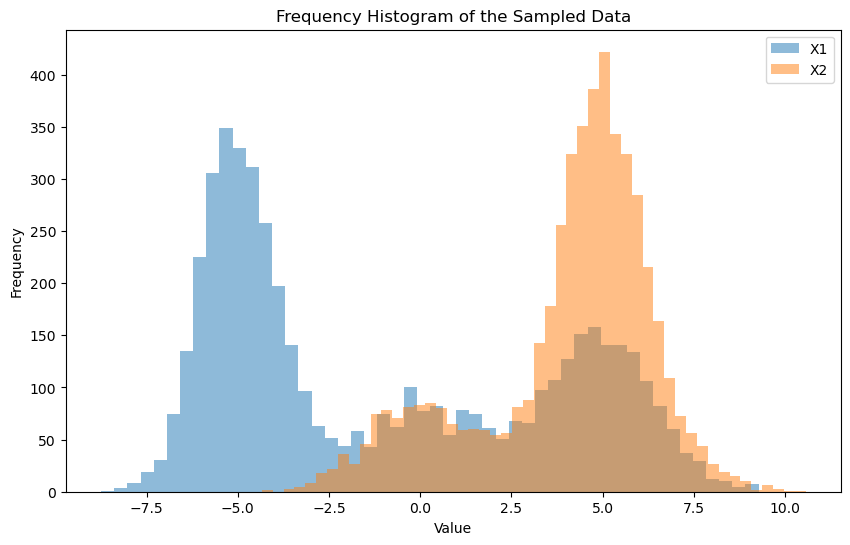

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# 设定三个多元高斯分布的参数
params = {
    "mean": [np.array([0, 0]), np.array([5, 5]), np.array([-5, 5])],
    "cov": [np.array([[3, 1], [1, 2]]), np.array([[2, -1], [-1, 3]]), np.array([[1, 0], [0, 1]])],
    "coef": [0.2, 0.3, 0.5]
}

# 抽取5000个样本点
num_samples = 5000
samples = []
for _ in range(num_samples):
    # 根据混合系数决定从哪个高斯分布中抽样
    k = np.random.choice([0, 1, 2], p=params["coef"])
    # 抽样
    sample = np.random.multivariate_normal(params["mean"][k], params["cov"][k])
    samples.append(sample)

samples = np.array(samples)

# 绘制频率直方图
plt.figure(figsize=(10, 6))
plt.hist(samples[:, 0], bins=50, alpha=0.5, label='X1')
plt.hist(samples[:, 1], bins=50, alpha=0.5, label='X2')
plt.title('Frequency Histogram of the Sampled Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


第1次迭代：
mean = [[ 3.01615088  2.78200111]
 [-5.31803115  5.23004913]
 [-4.09831153  5.01903075]]
cov = [[[8.77363446 6.23532939]
  [6.23532939 8.02677647]]

 [[1.0625066  0.12304858]
  [0.12304858 0.95087488]]

 [[5.46990553 1.89728433]
  [1.89728433 1.6230333 ]]]
coef = [0.47420546 0.22372897 0.30206557]
log_likelihood = -258055.49493519467

第2次迭代：
mean = [[ 3.01658015  2.94084649]
 [-5.22834127  5.19156681]
 [-4.42712795  4.84076229]]
cov = [[[ 8.59130365  6.11577261]
  [ 6.11577261  8.59195087]]

 [[ 0.75632    -0.014729  ]
  [-0.014729    0.89358618]]

 [[ 3.29112068  1.04421376]
  [ 1.04421376  1.28429393]]]
coef = [0.49020422 0.27369791 0.23609787]
log_likelihood = -290292.70879031305

第3次迭代：
mean = [[ 3.00299967  3.02817404]
 [-5.19134186  5.15420519]
 [-4.69281145  4.72197004]]
cov = [[[ 8.46802692  5.95582645]
  [ 5.95582645  8.8566452 ]]

 [[ 0.71220063 -0.04475859]
  [-0.04475859  0.88693616]]

 [[ 1.58244363  0.31414733]
  [ 0.31414733  0.98820889]]]
coef = [0.49961281 0.300

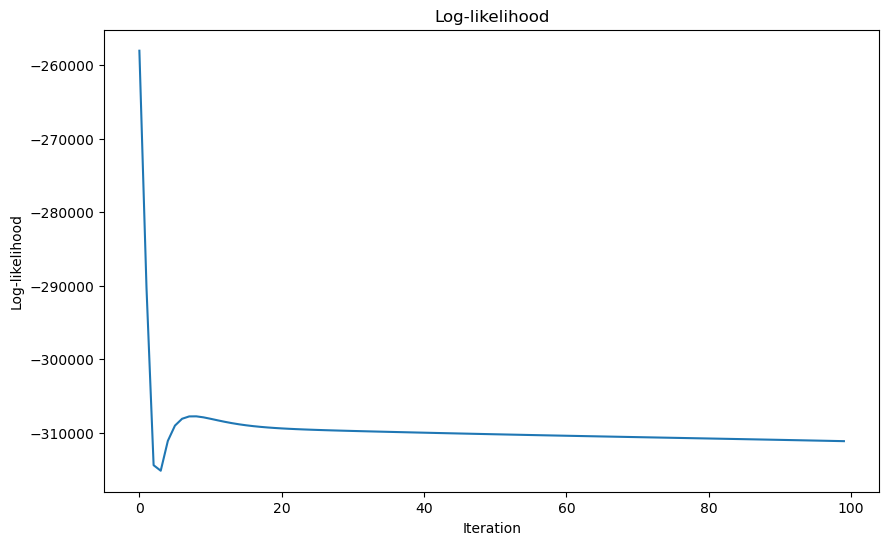

In [4]:
def initialize_parameters(samples, num_components=3):
    """初始化参数"""
    np.random.seed(42)  # 保证可重复性
    mean = samples[np.random.choice(samples.shape[0], num_components, False)]
    cov = np.array([np.eye(samples.shape[1])] * num_components)
    coef = np.ones(num_components) / num_components
    return mean, cov, coef

def e_step(samples, mean, cov, coef):
    """E步骤 - 计算责任度"""
    responsibilities = np.zeros((samples.shape[0], len(coef)))
    for k, (mu, sigma, pi) in enumerate(zip(mean, cov, coef)):
        rv = multivariate_normal(mu, sigma)
        responsibilities[:, k] = pi * rv.pdf(samples)
    responsibilities /= responsibilities.sum(axis=1, keepdims=1)
    return responsibilities

def m_step(samples, responsibilities):
    """M步骤 - 更新参数"""
    num_components = responsibilities.shape[1]
    Nk = responsibilities.sum(axis=0)
    mean = np.dot(responsibilities.T, samples) / Nk[:, np.newaxis]
    cov = np.zeros((num_components, samples.shape[1], samples.shape[1]))
    for k in range(num_components):
        diff = samples - mean[k]
        cov[k] = np.dot(responsibilities[:, k] * diff.T, diff) / Nk[k]
    coef = Nk / samples.shape[0]
    return mean, cov, coef

def log_likelihood(samples, mean, cov, coef):
    """计算似然度"""
    ll = 0
    for mu, sigma, pi in zip(mean, cov, coef):
        rv = multivariate_normal(mu, sigma)
        ll += np.log(pi * rv.pdf(samples)).sum()
    return ll

# 初始化参数
mean, cov, coef = initialize_parameters(samples)

# EM算法
log_likelihoods = []
max_iter = 100
for i in range(max_iter):
    old_mean = mean.copy()
    # E步骤
    responsibilities = e_step(samples, mean, cov, coef)
    # M步骤
    mean, cov, coef = m_step(samples, responsibilities)
    # 计算似然度
    ll = log_likelihood(samples, mean, cov, coef)
    log_likelihoods.append(ll)
    #输出参数和似然度：
    print(f"第{i+1}次迭代：")
    print(f"mean = {mean}")
    print(f"cov = {cov}")
    print(f"coef = {coef}")
    print(f"log_likelihood = {ll}")
    print()

    # 检查收敛
    if np.allclose(old_mean, mean):
        break

# 绘制似然度曲线    
plt.figure(figsize=(10, 6))
plt.plot(log_likelihoods)
plt.title("Log-likelihood")
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.show()

